<a href="https://colab.research.google.com/github/mohitpavan123/1st-colab/blob/master/Copy_of_DIP_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python==3.4.2.16

!pip install opencv-contrib-python==3.4.2.16


     |████████████████████████████████| 25.0MB 150kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 157kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
!python3 "/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/src/main_train.py"

Genuine Signatures
Disguise Signatures
Simulated Signatures
<Figure size 800x800 with 1 Axes>
<Figure size 800x800 with 1 Axes>
		Genuine	Fake
Genuine		61	15
Disguise	11	9
Simulated	10	94


In [3]:
""" Create the Reference Database """
import os
import cv2
import numpy as np

def createDB(path):
    """ Create the Reference Database """

    # Load Images
    img = []
    file_names = os.listdir(path)
    for img_name in file_names:
        l = len(img_name)
        if img_name[l - 4: l] == ".png":
            img.append(cv2.imread(path + img_name, cv2.IMREAD_GRAYSCALE))
    img = np.array(img)

    # Perform SURF for each Reference Image
    surf_db = []
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)
    for i in range(img.shape[0]):
        kp, des = surf.detectAndCompute(img[i], None)
        surf_db.append(des)
    surf_db = np.array(surf_db)

    # Find stable keypoints
    finalDB = []
    for i in range(img.shape[0]):
        # Generate LOO database
        indexes = list(range(img.shape[0]))
        indexes.remove(i)
        tmp_db = np.concatenate(surf_db[indexes])

        # Find minimum distance for each keypoint
        sum_dist = 0
        distances = []
        for keypoint in surf_db[i]:
            min_dist = np.min(np.linalg.norm(tmp_db - keypoint, axis=1))
            sum_dist += min_dist
            distances.append(min_dist)
        avg_dist = sum_dist / surf_db[i].shape[0]

        # Append keypoints less than average distance
        indexes = np.where(distances <= avg_dist)
        finalDB.extend(list(surf_db[i][indexes]))

    finalDB = np.stack(finalDB)
    return finalDB

In [ ]:
""" Classification Functions """
import os
import cv2
import threading
import numpy as np

def classify_matched(test_img, DB, threshold, match, idx):
    """ Classify matched points """

    # Compute SURF Keypoints
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)
    kp, des = surf.detectAndCompute(test_img, None)

    # Match Keypoints
    matched_points = 0
    for keypoint in des:
        min_dist = np.min(np.linalg.norm(DB - keypoint, axis=1))
        if min_dist <= threshold:
            matched_points += 1

    # Return percentage of matched keypoints and avg distance
    match[idx] = matched_points / des.shape[0]
    return

def thread_helper(path, DB, threshold, test_size = None):
    """ Thread helper function for running classify_matched """

    # Load File names
    file_names = os.listdir(path)
    if test_size is not None:
        file_names = file_names[:test_size]

    # Variables
    idx = 0
    limit = 10
    threads = [None] * limit
    match = [None] * len(file_names)

    # Generate matched points percentage for each signature type
    for i, img_name in enumerate(file_names):
        # Run only limit number of threads
        if idx % limit == 0 and idx != 0:
            for j in range(limit):
                threads[j].join()
            idx = 0
        # Run thread
        threads[idx] = threading.Thread(target = classify_matched,
                       args = (cv2.imread(path + img_name, cv2.IMREAD_GRAYSCALE),
                       DB, threshold, match, i))
        threads[idx].start()
        idx += 1

    # Join remaining threads
    for j in range(idx):
        threads[j].join()
    return np.array(match)

In [ ]:
""" Plot Functions """
import matplotlib.pyplot as plt

def plot_matches(genuine_match, disguise_match, simulated_match, threshold):
    """ Plot Match Point percentages """

    plt.figure(figsize = (8, 8))
    match = [genuine_match, disguise_match, simulated_match]
    plt.hist(match, label=['Genuine', 'Disguise', 'Simulated'])
    plt.legend()
    plt.title('Matched Points')
    plt.savefig('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Plots/PMatchpoints' + str(threshold) + '.jpg')
    plt.show()

def plot_EER(theta_range, far, frr, threshold):
    """ Plot EER vs Theta """

    plt.figure(figsize = (8, 8))
    plt.plot(theta_range, far, color = 'red')
    plt.plot(theta_range, frr, color = 'blue')
    plt.title('EER vs Theta')
    plt.legend(['FAR', 'FRR'])
    plt.savefig('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Plots/Error' + str(threshold) + '.jpg')
    plt.show()

Genuine Signatures
Disguise Signatures
Simulated Signatures


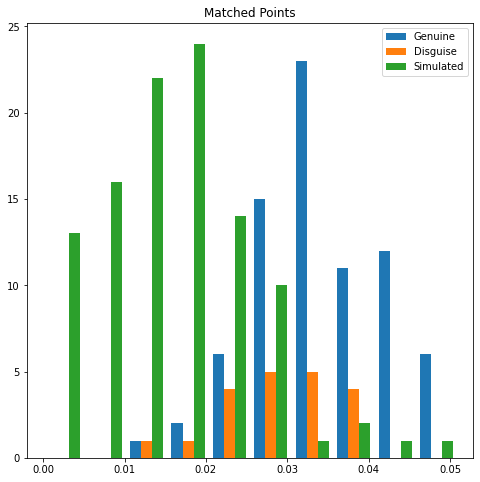

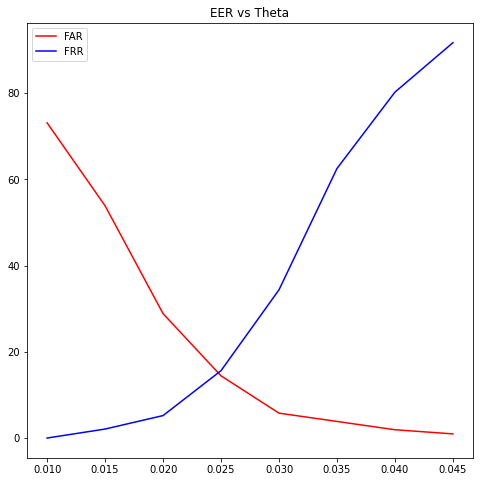

		Genuine	Fake
Genuine		61	15
Disguise	11	9
Simulated	10	94


In [ ]:
""" Generating Database and Graphs for Train set """

import os
import cv2
import pickle
import threading
import numpy as np
import matplotlib.pyplot as plt
# User defined Modules


############################### Helper Functions ##############################
def display_images(image):
    cv2.imshow('Showing image', image)
    cv2.waitKey()

def storeData(dat, filename):
    dbfile = open(filename, 'wb')
    pickle.dump(dat, dbfile)
    dbfile.close()

def loadData(filename):
    dbfile = open(filename, 'rb')
    return pickle.load(dbfile)
###############################################################################


# Load/Save DB
DB = createDB('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Reference/')
storeData(DB, '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database.pkl')
DB = loadData('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database.pkl')
threshold = 0.11


# Matched Points Percentage for each type of signature
print("Genuine Signatures")
genuine_match = thread_helper('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Genuine/', DB, threshold)
print("Disguise Signatures")
disguise_match = thread_helper('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Disguise/', DB, threshold)
print("Simulated Signatures")
simulated_match = thread_helper('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Simulated/', DB, threshold)


# Save/Load percentages (for convenience)
storeData([genuine_match, disguise_match, simulated_match], '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals' +
                                            str(threshold) + '.pkl')
genuine_match, disguise_match, simulated_match = loadData('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals' +
                                          str(threshold) + '.pkl')
plot_matches(genuine_match, disguise_match, simulated_match, threshold)


# Calculate FAR and FRR
far = []
frr = []
theta_range = np.arange(0.01, 0.05, 0.005)
for theta in theta_range:
    ind1 = np.where(genuine_match < theta)
    ind2 = np.where(disguise_match < theta)
    ind3 = np.where(simulated_match > theta)
    frr.append((ind1[0].shape[0] + ind2[0].shape[0]) / (genuine_match.shape[0] + disguise_match.shape[0]) * 100)
    far.append(ind3[0].shape[0] / simulated_match.shape[0] * 100)
plot_EER(theta_range, far, frr, threshold)


# Compute Confidence Matrix
eer = 0.0275
ind = np.where(genuine_match < eer)
ind1 = np.where(disguise_match < eer)
ind2 = np.where(simulated_match > eer)
print('\t\tGenuine\tFake')
print('Genuine\t\t' + str(genuine_match.shape[0] - ind[0].shape[0]) + '\t' + str(ind[0].shape[0]))
print('Disguise\t' + str(disguise_match.shape[0] - ind1[0].shape[0]) + '\t' + str(ind1[0].shape[0]))
print('Simulated\t' + str(ind2[0].shape[0]) + '\t' + str(simulated_match.shape[0] - ind2[0].shape[0]))

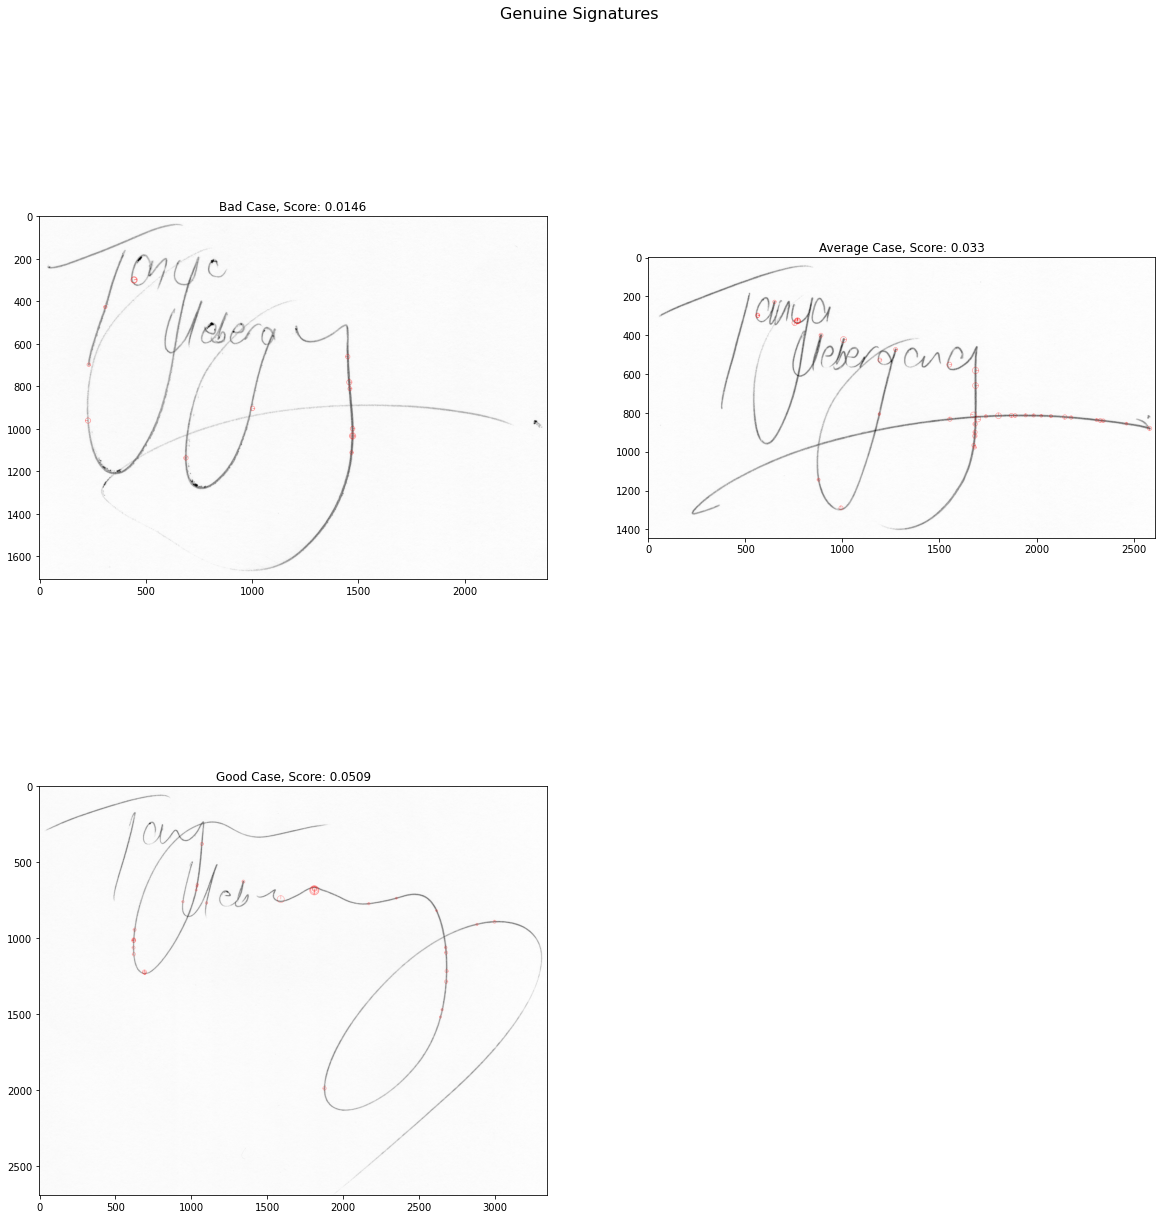

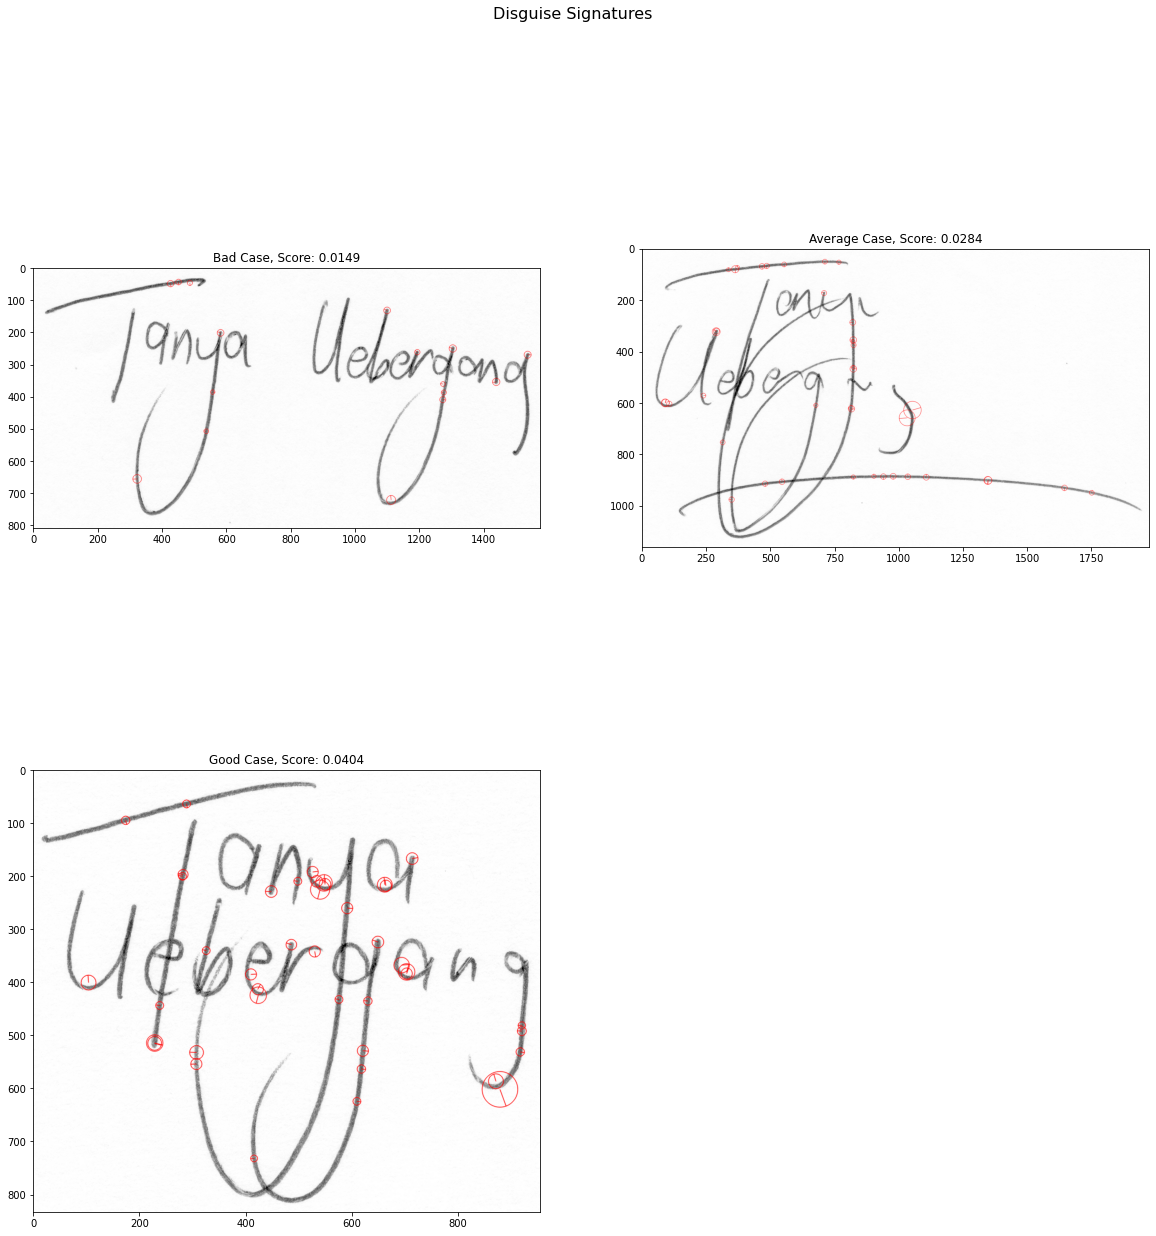

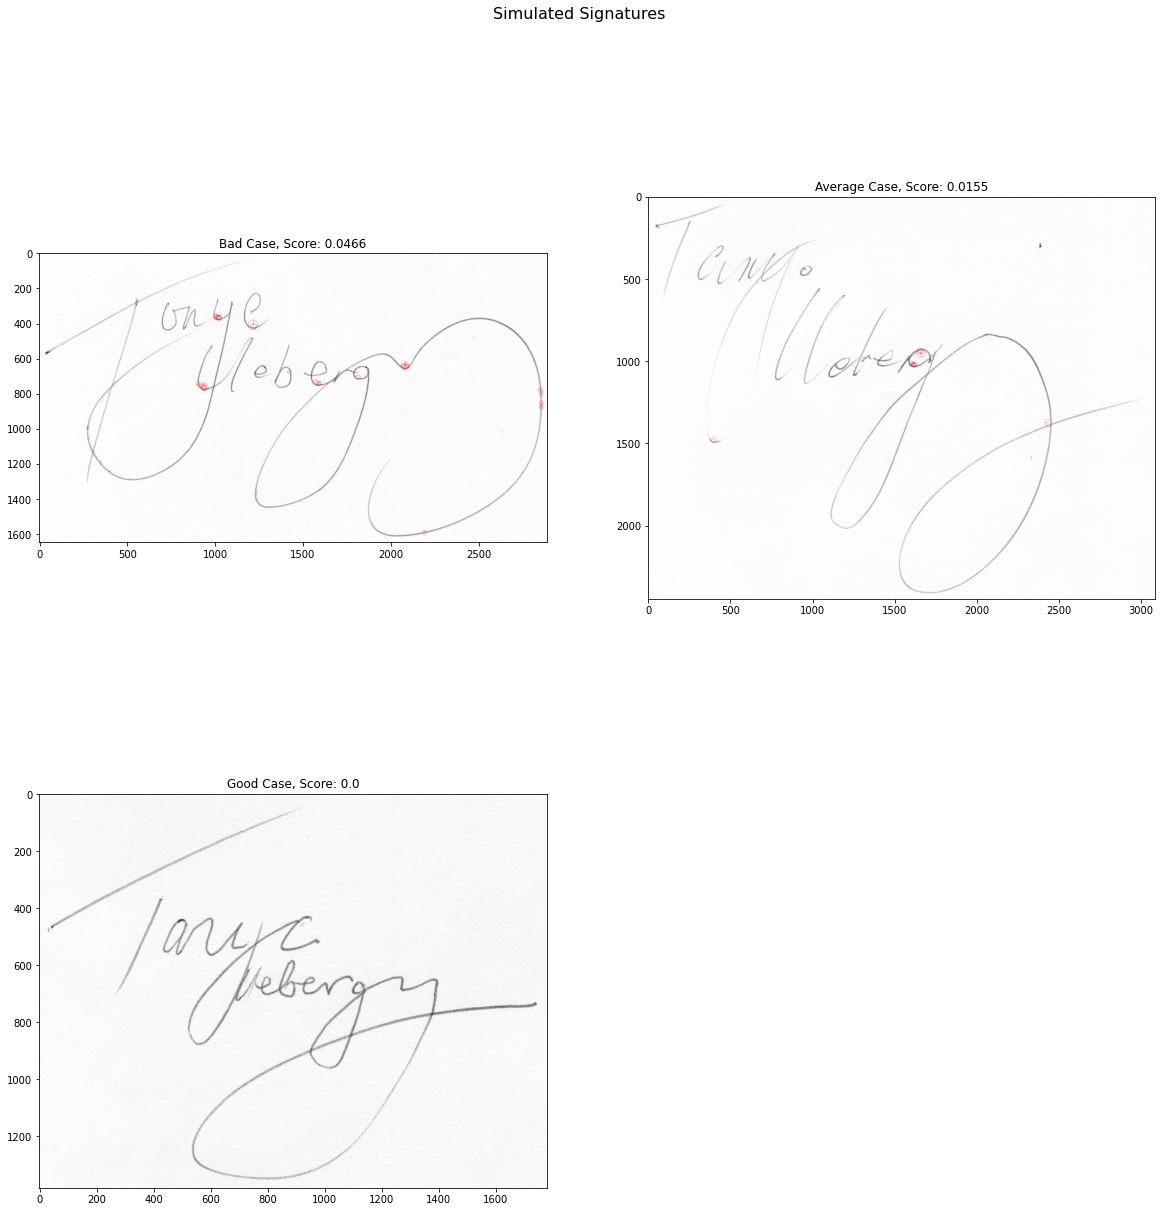

In [ ]:
""" Demo to show working of Algorithm """

import os
import cv2
import pickle
import threading
import numpy as np
import matplotlib.pyplot as plt


############################### Helper Functions ##############################
def display_images(image):
    cv2.imshow('Showing image', image)
    cv2.waitKey()

def storeData(dat, filename):
    dbfile = open(filename, 'wb')
    pickle.dump(dat, dbfile)
    dbfile.close()

def loadData(filename):
    dbfile = open(filename, 'rb')
    return pickle.load(dbfile)
###############################################################################


def annotate(test_img, DB, threshold):
    """ Annotate keypoints """

    # Compute SURF Keypoints
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)
    kp, des = surf.detectAndCompute(test_img, None)

    # Find matching and non-matching Keypoints
    kp1 = []
    for i in range(des.shape[0]):
        min_dist = np.min(np.linalg.norm(DB - des[i], axis=1))
        if min_dist <= threshold:
            kp1.append(kp[i])

    # Annotate image
    test_img = cv2.drawKeypoints(test_img, kp1, None, (255,0,0), 4)
    return test_img


# Load Pre-generated refernce database and match percentages
threshold = 0.11
DB = loadData('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database.pkl')
genuine_match, disguise_match, simulated_match = loadData('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals' +
                                          str(threshold) + '.pkl')
# Find good, bad and average cases
gm = np.argsort(genuine_match)
dm = np.argsort(disguise_match)
sm = np.argsort(simulated_match)
gm = gm[[0, int(gm.shape[0] / 2), -1]]
dm = dm[[0, int(dm.shape[0] / 2), -1]]
sm = sm[[-1, int(sm.shape[0] / 2), 0]]
matches = np.concatenate((genuine_match[gm], disguise_match[dm], simulated_match[sm]))


# Annotate the image with SURF keypoints
img = []
for i, type in enumerate(['Genuine', 'Disguise', 'Simulated']):
    path = '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/' + type + '/'
    file_names = os.listdir(path)
    for j in [gm, dm, sm][i]:
        img.append(annotate(cv2.imread(path + file_names[j],
                             cv2.IMREAD_GRAYSCALE), DB, threshold))


# Display
for i, type in enumerate(['Genuine', 'Disguise', 'Simulated']):
    fig = plt.figure(figsize = (20, 20))
    fig.suptitle(type + ' Signatures', fontsize = 16)
    for j, case in enumerate(['Bad Case', 'Average Case', 'Good Case']):
        plt.subplot(2, 2, j + 1)
        plt.imshow(img[3 * i + j])
        plt.title(case + ', Score: ' + str(round(matches[3 * i + j], 4)))
    plt.savefig('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Plots/Demo' + str(i + 1) + '.jpg')
    plt.show()

Questioned Signatures


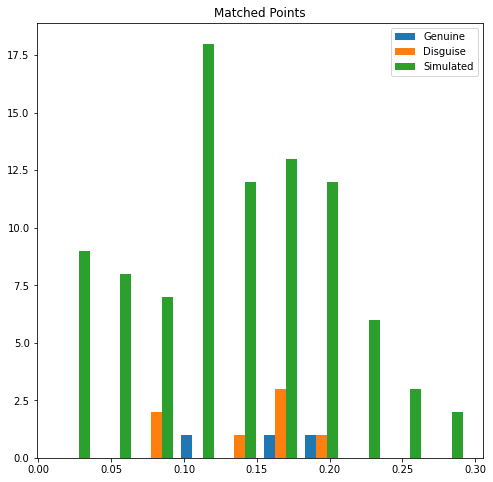

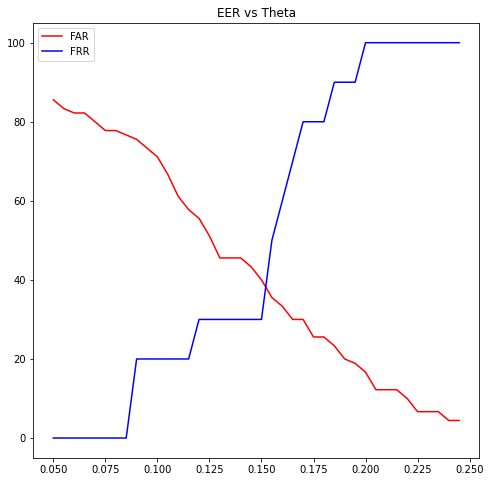

		Genuine	Fake
Genuine		0	3
Disguise	0	7
Simulated	6	84


In [ ]:
""" Generating Database and Graphs for Test set """

import os
import cv2
import pickle
import threading
import numpy as np
import matplotlib.pyplot as plt
# User defined Modules
#from createDB import createDB
#from plots import plot_matches, plot_EER
#from classify import classify_matched, thread_helper


############################### Helper Functions ##############################
def display_images(image):
    cv2.imshow('Showing image', image)
    cv2.waitKey()

def storeData(dat, filename):
    dbfile = open(filename, 'wb')
    pickle.dump(dat, dbfile)
    dbfile.close()

def loadData(filename):
    dbfile = open(filename, 'rb')
    return pickle.load(dbfile)
###############################################################################


# Load/Save DB
DB = createDB('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TestSet/Reference/')
storeData(DB, '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database_test.pkl')
DB = loadData('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database_test.pkl')
threshold = 0.11


# Matched Points Percentage for each type of signature
print("Questioned Signatures")
match = thread_helper('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TestSet/Questioned/', DB, threshold)
genuine_match = match[[48, 51, 65]]
disguise_match = match[[5, 14, 27, 28, 33, 86, 89]]
simulated_match = match[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17,
18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40,
41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
84, 85, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]


# Save/Load percentages (for convenience)
storeData([genuine_match, disguise_match, simulated_match], '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals_test.pkl')
genuine_match, disguise_match, simulated_match = loadData('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals_test.pkl')
plot_matches(genuine_match, disguise_match, simulated_match, '_test')


# Calculate FAR and FRR
far = []
frr = []
theta_range = np.arange(0.05, 0.25, 0.005)
for theta in theta_range:
    ind1 = np.where(genuine_match < theta)
    ind2 = np.where(disguise_match < theta)
    ind3 = np.where(simulated_match > theta)
    frr.append((ind1[0].shape[0] + ind2[0].shape[0]) / (genuine_match.shape[0] + disguise_match.shape[0]) * 100)
    far.append(ind3[0].shape[0] / simulated_match.shape[0] * 100)
plot_EER(theta_range, far, frr, threshold)


# Compute Confidence Matrix
eer = 0.224
ind = np.where(genuine_match < eer)
ind1 = np.where(disguise_match < eer)
ind2 = np.where(simulated_match > eer)
print('\t\tGenuine\tFake')
print('Genuine\t\t' + str(genuine_match.shape[0] - ind[0].shape[0]) + '\t' + str(ind[0].shape[0]))
print('Disguise\t' + str(disguise_match.shape[0] - ind1[0].shape[0]) + '\t' + str(ind1[0].shape[0]))
print('Simulated\t' + str(ind2[0].shape[0]) + '\t' + str(simulated_match.shape[0] - ind2[0].shape[0]))

In [ ]:
!python3 "/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/src/demo.py"

<Figure size 2000x2000 with 3 Axes>
<Figure size 2000x2000 with 3 Axes>
<Figure size 2000x2000 with 3 Axes>
